# Building a Network for the number of Components $K$

We want to build a network to learn the relationship between data and the number of components $K$ that make up the data. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/daniela/work/repositories/jumpingflows/code/") 

import seaborn as sns
sns.set_style("whitegrid")

import numpy as np

import torch

## Simplifying the Problem

I'm going to simplify the problem somewhat: a background parameter + two parameters per component (amplitude and position), and I'm also going to set the maximum number of $K$ to 5. 

Let's write a function to do that: 

In [2]:
from generate_data import simulate_burst

In [6]:
def simulate_burst_simple(time, ncomp, burstparams, return_model=False):
    """
    Simpler version of the the `simulate_burst` function 
    with fewer parameters. 
    
    We will set rise time, skewness and backgroung flux 
    to a constant value, which only leaves the peak time 
    and the amplitude as free parameters.

    **Important**: The amplitude in `burstparams` is defined 
    as a **log(amplitude)**, in contrast to the original 
    `generate_data` function, to make sampling easier.
    
    Parameters
    ---------
    time : numpy.ndarray
        The array of time stamps for which to compute 
        the model
        
    ncomp : int
        The number of `twoexp` components to include 
        in the sum

    burstparams : iterable
        An array containing the parameters for the 
        `twoexp` model. Flat array of the form
        `[t0_1, ..., t0_K, log(amp_1), ..., log(amp_K)]`
          
    ybkg : float
        The background flux
        
    return_model : bool, default False
        If True, return the model flux (without Poisson
        counts) along with the Poisson-drawn model 
        counts. If False, just contain the Poisson counts

    Returns
    -------
    ycounts : numpy.ndarray
        An array of the same size of $t$, returning the 
        model counts    
    """
    # set the fixed parameters for the simplified model
    ybkg = 10.0
    rise = np.ones(ncomp) * 0.02
    skew = np.ones(ncomp) * 3.0
    
    t0 = burstparams[:ncomp]
    amp = burstparams[ncomp:]
    
    burstparams_full = np.hstack([burstparams, rise, skew])
    
    if return_model:
        ym, ycounts = simulate_burst(time, ncomp, burstparams_full, ybkg, return_model=return_model)
        return ym, ycounts
    
    else: 
        ycounts = simulate_burst(time, ncomp, burstparams_full, ybkg, return_model=return_model)
        return ycounts

    

Okay, cool, next let's define some global parameters and some priors.

In [16]:
tstart = 0.0
tend = 1.0
nsteps = 1000

time = np.linspace(tstart, tend, nsteps)
dt = time[1] - time[0]

ybkg = 10.0

kmax = 5 # maximum number of components

# uniform prior on log-amplitude minimum 
# and maximum
log_amin = np.log(ybkg/2.0) 
log_amax = np.log(20*ybkg)

# uniform prior on peak time minimum 
# and maximum
tmin = tstart+0.1 #
tmax = tend - 0.1

Now we can use these to sample parameters from the prior:

In [26]:
nsims = 100000 # number of simulations to produce

# first, sample number of components in each simulation
k_all = np.random.randint(1, kmax+1, size=nsims)

# now loop over components and generate burst parameters 
# and data:
ymodel_all = np.zeros((nsims, time.shape[0]))
ycounts_all = np.zeros((nsims, time.shape[0]))
burstparams_all = []

for i, k in enumerate(k_all):
    log_amp = np.random.uniform(log_amin, log_amax, size=k)
    t0 = np.random.uniform(tmin, tmax, size=k)
    
    burstparams = np.hstack([t0, np.exp(log_amp)])
    burstparams_all.append(burstparams)
    
    ym, yc = simulate_burst_simple(time, k, burstparams, return_model=True)
    ymodel_all[i,:] = ym
    ycounts_all[i,:] = yc

In [29]:
#np.savetxt("/Users/daniela/work/data/jumpingflows_simplified_bursts_data.dat", ycounts_all)
#np.savetxt("/Users/daniela/work/data/jumpingflows_simplified_bursts_k.dat", k_all)

<IPython.core.display.Javascript object>


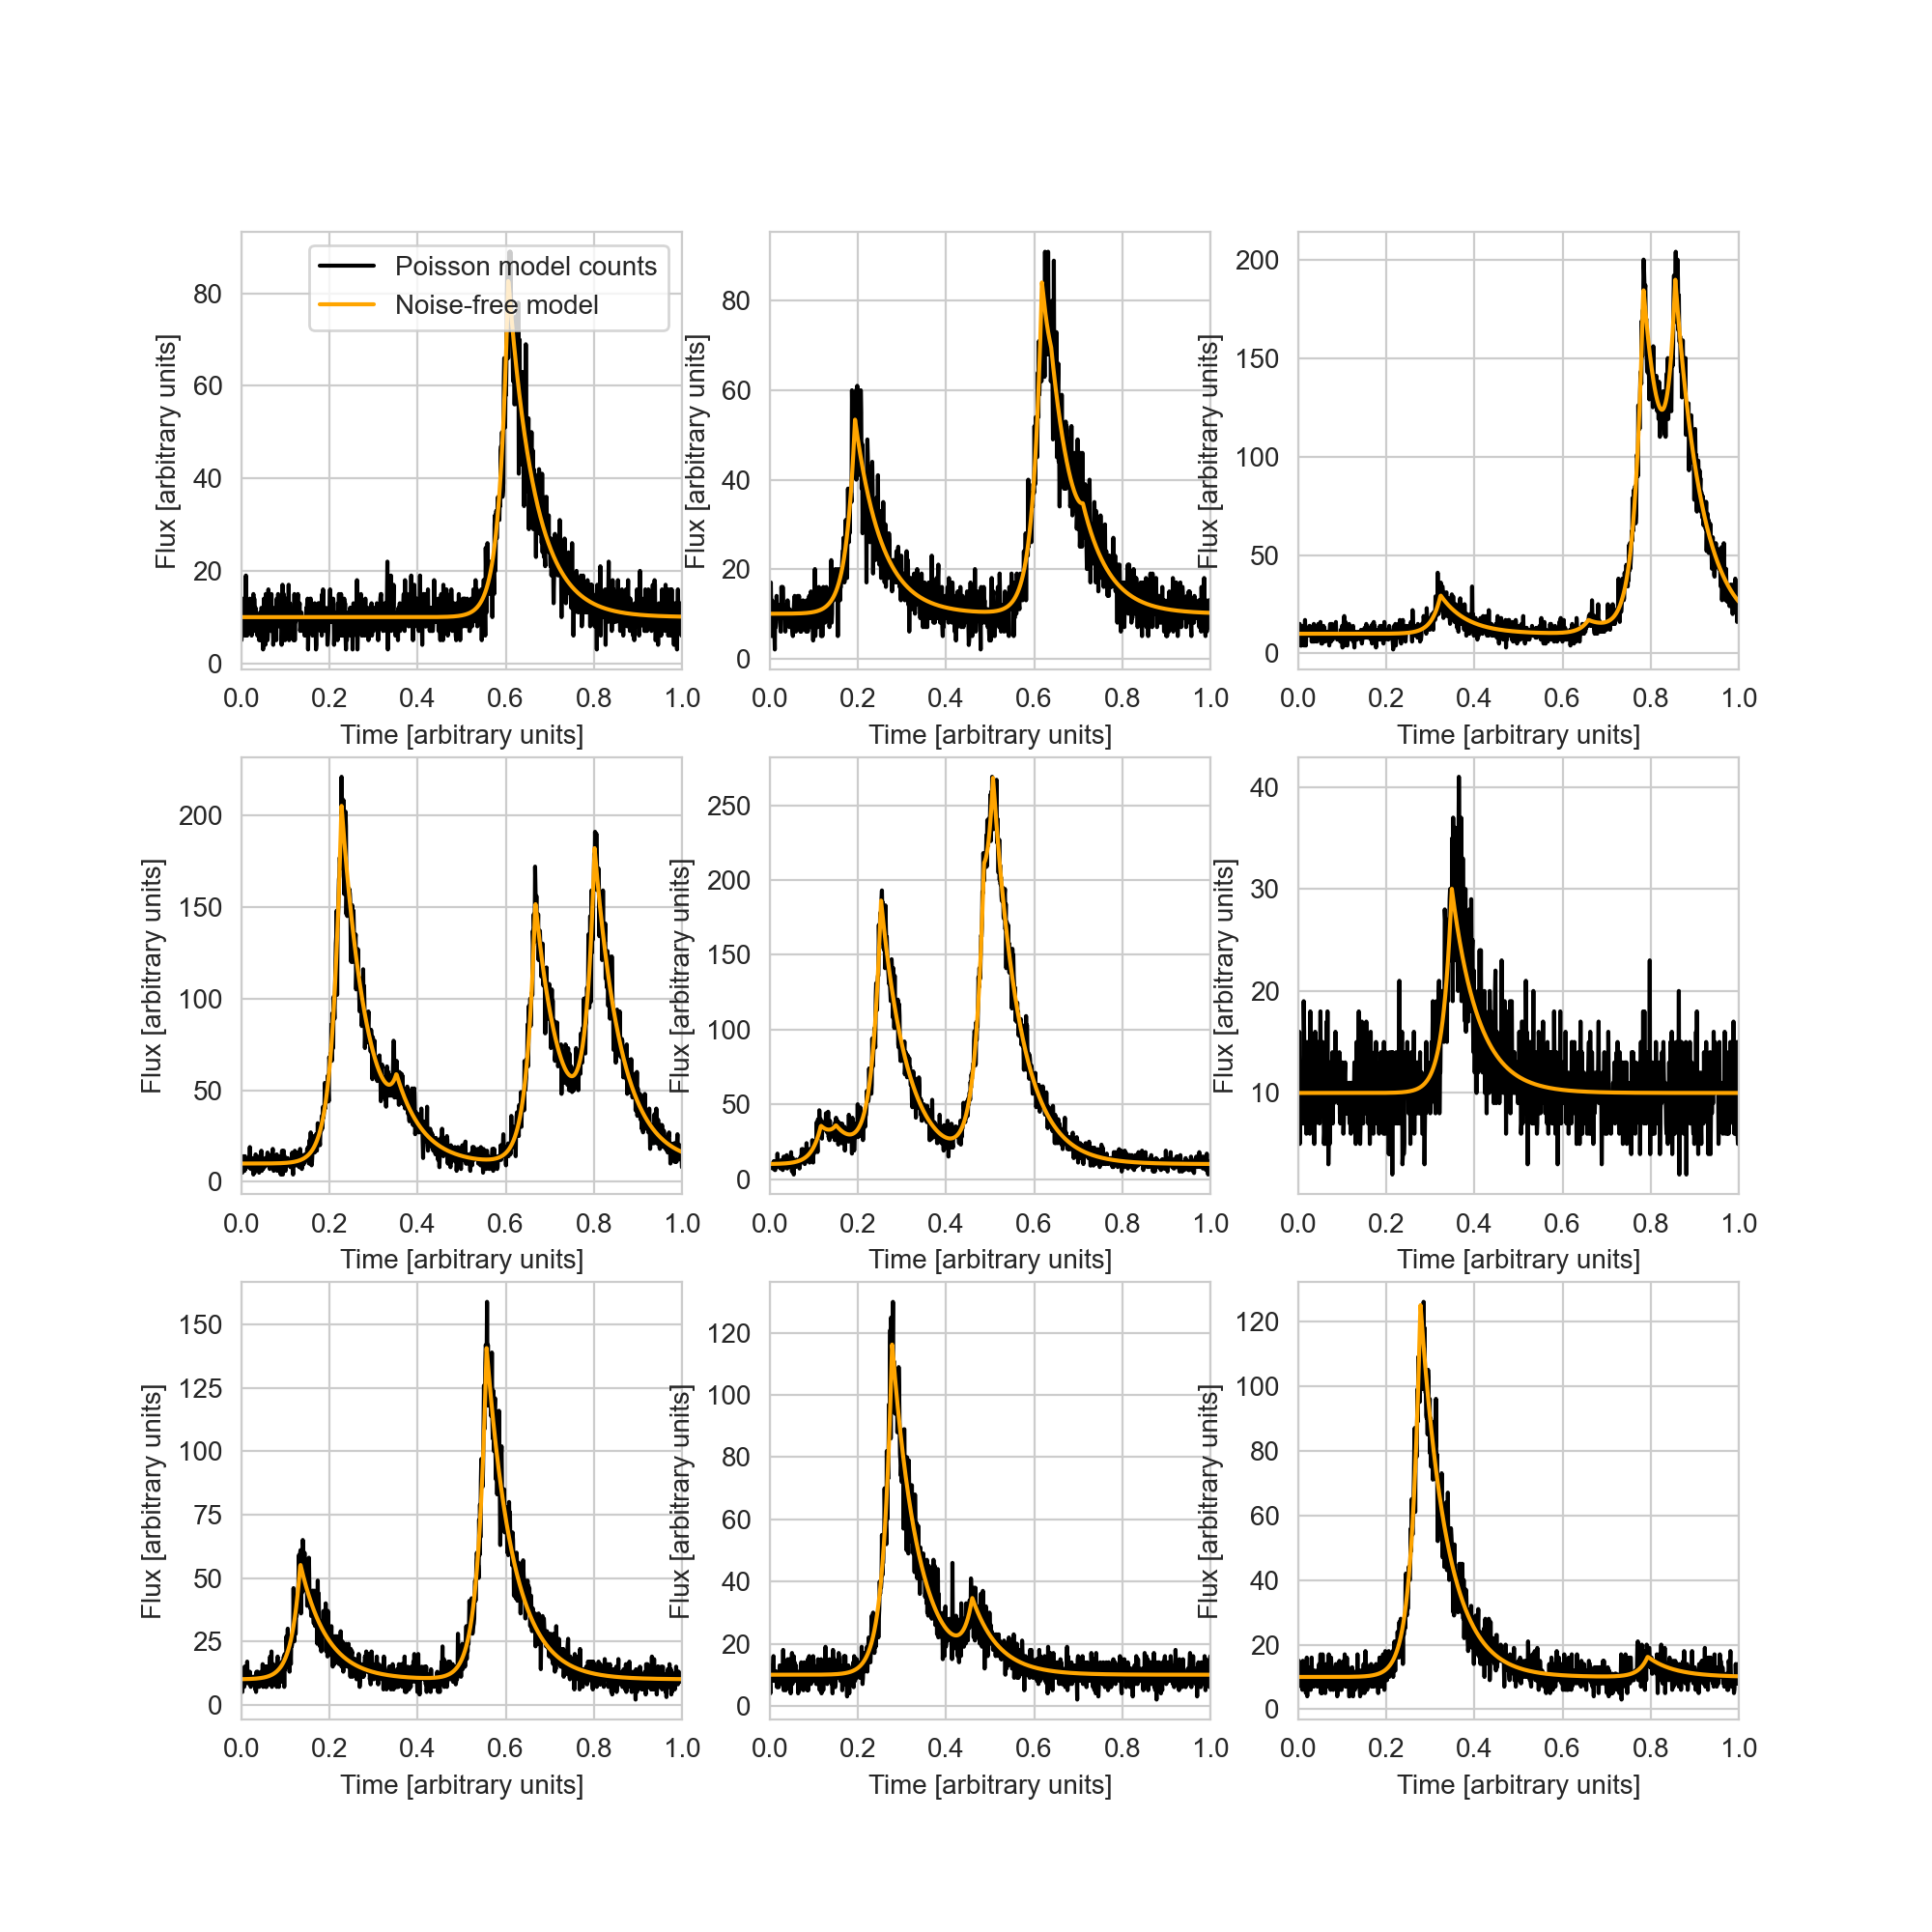

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i, ax in enumerate(axes):
    ax.plot(time, ycounts_all[i,:], color="black", label="Poisson model counts")
    ax.plot(time, ymodel_all[i,:], color="orange", label="Noise-free model")
    ax.set_xlabel("Time [arbitrary units]")
    ax.set_ylabel("Flux [arbitrary units]")
    ax.set_xlim(time[0], time[-1]);
    if i == 0:
        ax.legend();

## The Simplest Training Data Set

For debugging purposes:

In [ ]:
tstart = 0.0
tend = 1.0
nsteps = 1000

time = np.linspace(tstart, tend, nsteps)
dt = time[1] - time[0]

ybkg = 10.0

kmax = 5 # maximum number of components

# uniform prior on log-amplitude minimum 
# and maximum
log_amin = np.log(ybkg/2.0) 
log_amax = np.log(20*ybkg)

# uniform prior on peak time minimum 
# and maximum
tmin = tstart + 0.1 #
tmax = tend - 0.1

In [266]:
nsims = 55000 # number of simulations to produce

# first, sample number of components in each simulation
k_all = np.random.randint(1, kmax+1, size=nsims)

# now loop over components and generate burst parameters 
# and data:
ymodel_all = np.zeros((nsims, time.shape[0]))
ycounts_all = np.zeros((nsims, time.shape[0]))
burstparams_all = []

t0_template = np.linspace(tstart+0.2, tend-0.2, 5)

for i, k in enumerate(k_all):
    #log_amp = np.random.uniform(log_amin, log_amax, size=k)
    #t0 = np.random.uniform(tmin, tmax, size=k)
    
    t0 = t0_template[:k]
    log_amp = np.ones(k) * np.log(500)
    
    burstparams = np.hstack([t0, np.exp(log_amp)])
    burstparams_all.append(burstparams)
    
    ym, yc = simulate_burst_simple(time, k, burstparams, return_model=True)
    ymodel_all[i,:] = ym
    ycounts_all[i,:] = yc

<IPython.core.display.Javascript object>


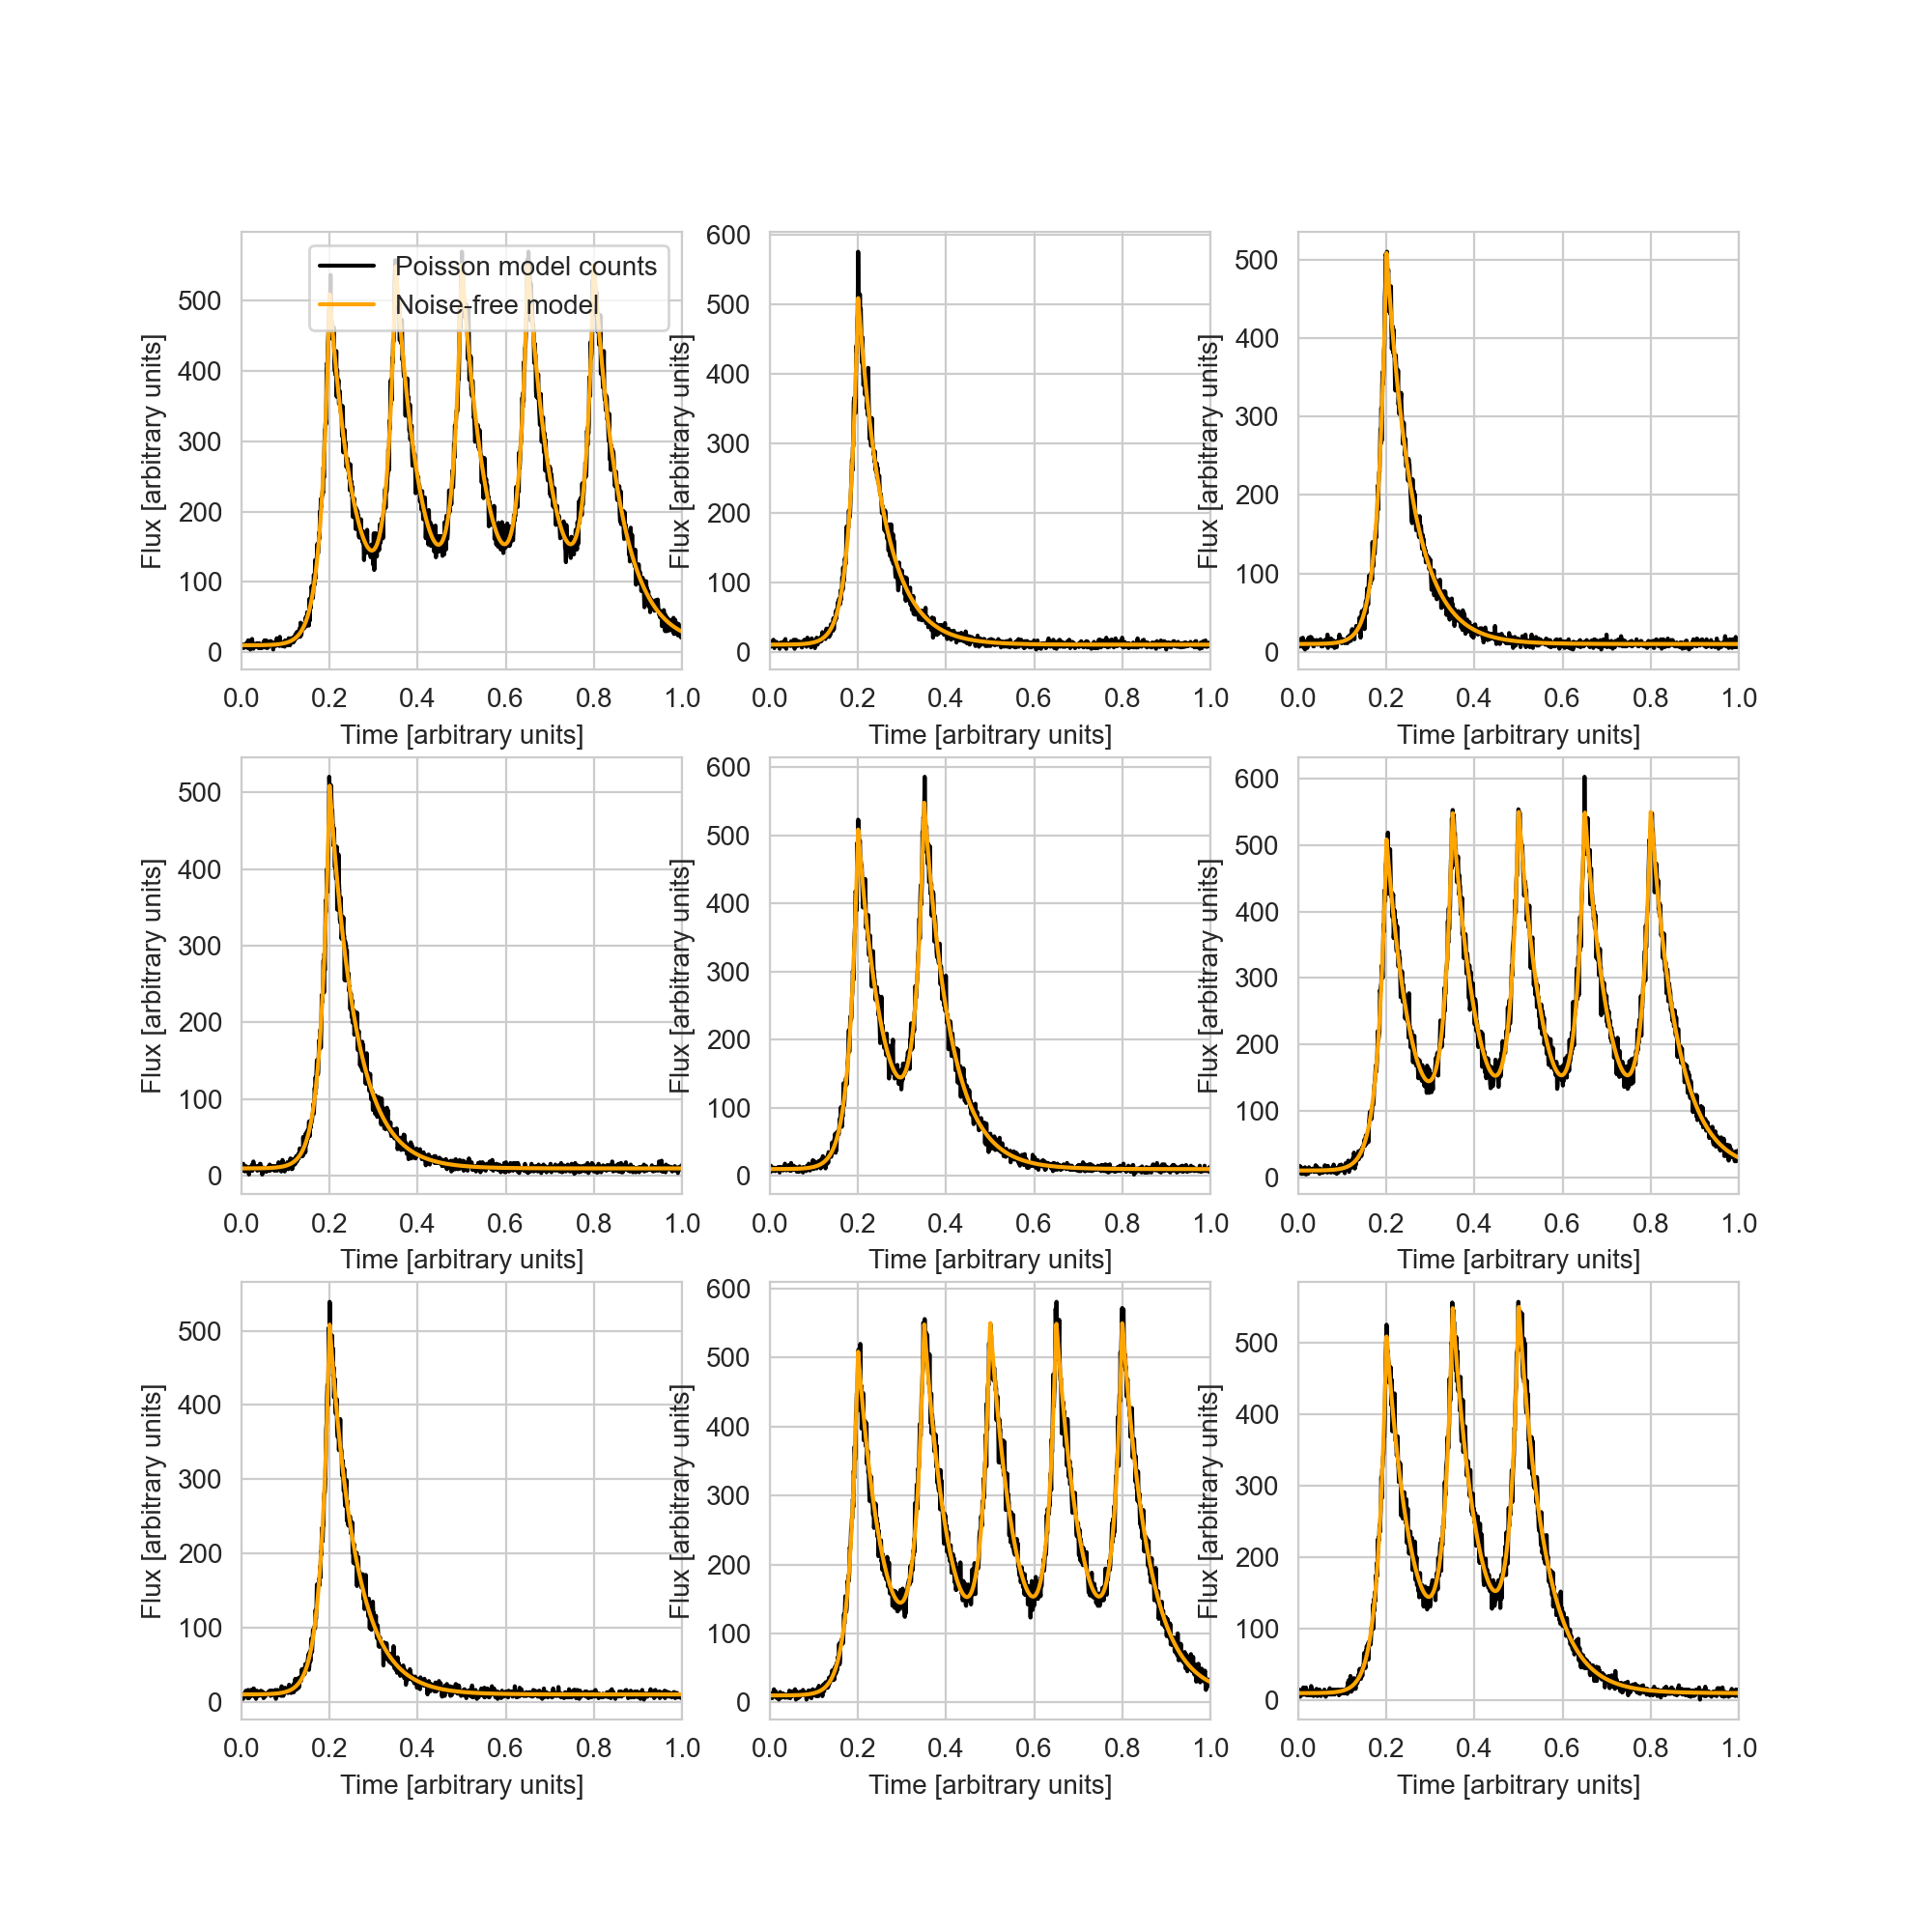

In [267]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i, ax in enumerate(axes):
    ax.plot(time, ycounts_all[i,:], color="black", label="Poisson model counts")
    ax.plot(time, ymodel_all[i,:], color="orange", label="Noise-free model")
    ax.set_xlabel("Time [arbitrary units]")
    ax.set_ylabel("Flux [arbitrary units]")
    ax.set_xlim(time[0], time[-1]);
    if i == 0:
        ax.legend();

In [268]:
from torch.utils.data import Dataset

class BurstDataset(Dataset):
    def __init__(self, ncomp, data, transform=None, target_transform=None):
        self.ncomp = torch.tensor(ncomp, dtype=torch.long) - 1
        self.data = torch.tensor(data, dtype=torch.float32)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.ncomp)

    def __getitem__(self, idx):
        ncomp = self.ncomp[idx]
        data = self.data[idx]
        
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            ncomp = self.target_transform(ncomp)
        return data, ncomp

In [269]:
Xtrain = BurstDataset(k_all[:50000], ycounts_all[:50000])
Xtest = BurstDataset(k_all[50000:], ycounts_all[50000:])

In [270]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(1000, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 5),
        nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [271]:
model = NeuralNetwork()

X = torch.rand(5, 1000)
logits = model(X)
print(logits)

tensor([[0.1965, 0.1846, 0.2104, 0.2105, 0.1979],
        [0.2014, 0.1883, 0.2218, 0.1985, 0.1900],
        [0.1936, 0.1899, 0.2278, 0.2053, 0.1834],
        [0.1969, 0.1869, 0.2206, 0.2059, 0.1898],
        [0.1974, 0.1883, 0.2235, 0.1992, 0.1916]], grad_fn=<SoftmaxBackward0>)


In [272]:
from torch.utils.data import DataLoader

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_dataloader = DataLoader(Xtrain, batch_size=256, shuffle=True)
test_dataloader = DataLoader(Xtest, batch_size=256, shuffle=True)

In [273]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #print(X.shape)
        # Compute prediction and loss
        pred = model(X)
        #print(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")



In [274]:
learning_rate = 0.01
batch_size = 256
epochs = 100

loss_fn = nn.CrossEntropyLoss()

In [275]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.852784  [  256/50000]
Test Error: 
 Avg loss: 1.691506 

Epoch 2
-------------------------------
loss: 1.701708  [  256/50000]
Test Error: 
 Avg loss: 1.692540 

Epoch 3
-------------------------------
loss: 1.701708  [  256/50000]
Test Error: 
 Avg loss: 1.691850 

Epoch 4
-------------------------------
loss: 1.709520  [  256/50000]
Test Error: 
 Avg loss: 1.690816 

Epoch 5
-------------------------------
loss: 1.717333  [  256/50000]
Test Error: 
 Avg loss: 1.690644 

Epoch 6
-------------------------------
loss: 1.713426  [  256/50000]
Test Error: 
 Avg loss: 1.690989 

Epoch 7
-------------------------------
loss: 1.678270  [  256/50000]
Test Error: 
 Avg loss: 1.690299 

Epoch 8
-------------------------------
loss: 1.682176  [  256/50000]
Test Error: 
 Avg loss: 1.691678 

Epoch 9
-------------------------------
loss: 1.713426  [  256/50000]
Test Error: 
 Avg loss: 1.691850 

Epoch 10
-------------------------------
loss: 1.740770

KeyboardInterrupt: 